## VAR vs VARMAX Model CV



In this notebook, we will validate which model performs better given computational constraints: a VAR model retrained after each prediction or a VARMAX retrained every 20 predictions. To do so, we will retrun the model and functions constructed in [Systems_Identification_Fitting](Systems_Identification_Fitting.ipynb).

In [1]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import math as m
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VARMAX
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import warnings
import os
import time
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
warnings.filterwarnings("ignore")

%matplotlib inline 

os.chdir('..')

states = pd.read_csv('data/states.1200.csv')
del states['Unnamed: 0']
states.head()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RaiDrawnFromSAFEs,collateral,debt,EthInUniswap,RaiInUniswap,ETH Price (OSM),block_timestamp
0,0.001476,3.115038,12163538,13643.859362,3.694647e+07,115792089237316195423570985008687.9,184447.332614,980,0.844051,0.999981,0.999845,3.033131,3.669856e+07,6921.6132,1.398615e+06,47370.263641,3.211457e+07,2130.090000,2021-04-03 01:10:15+00:00
1,0.001476,3.115038,12163808,13643.859362,3.694647e+07,115792089237316195423570985008687.9,184447.332614,980,0.844051,0.999981,0.999845,3.033072,3.669856e+07,6921.6132,1.398615e+06,47388.171967,3.210247e+07,2132.768622,2021-04-03 02:10:11+00:00
2,0.001476,3.115038,12164098,13643.859362,3.694647e+07,115792089237316195423570985008687.9,184447.332614,980,0.784730,0.999972,0.999779,3.032997,3.669856e+07,6913.6132,1.398615e+06,47387.538619,3.210178e+07,2115.468053,2021-04-03 03:10:28+00:00
3,0.001469,3.083544,12164400,13643.859362,3.701089e+07,115792089237316195423570985008687.9,184586.897248,980,0.784730,0.999972,0.999779,3.032912,3.676330e+07,6913.6132,1.398615e+06,47475.841207,3.217051e+07,2100.335393,2021-04-03 04:11:05+00:00
4,0.001463,3.094035,12164647,13643.859362,3.705626e+07,115792089237316195423570985008687.9,184629.005401,979,0.784730,0.999972,0.999779,3.032830,3.680853e+07,6911.2132,1.397797e+06,47245.283268,3.228967e+07,2093.917874,2021-04-03 05:09:44+00:00


In [2]:
# add additional state variables
states['RedemptionPriceinEth'] = states['RedemptionPrice'] / states['ETH Price (OSM)']
states['RedemptionPriceError'] = states['RedemptionPrice'] - states['marketPriceUsd']

In [3]:
# define constants (will come from cadCAD model but added here for calculations)
params = {
    'liquidation_ratio': 1.45,
    'debt_ceiling': 1e9,
    'uniswap_fee': 0.003,
    'arbitrageur_considers_liquidation_ratio': True,
}

<!-- ## Create Arbtrageur data vector $u^*$ -->

In [4]:
# subset state variables for arbitrageur vector
state_subset = states[['collateral','RaiDrawnFromSAFEs','RaiInUniswap','EthInUniswap']]

# map state data to vector fields 
state_subset.columns = ['Q','D','Rrai','Reth']

# alpha is the smoothing factor
local = state_subset.ewm(alpha=0.8).mean()
local

,Q,D,Rrai,Reth
0,6921.613200,3.669856e+07,3.211457e+07,47370.263641
1,6921.613200,3.669856e+07,3.210448e+07,47385.187246
2,6915.161587,3.669856e+07,3.210230e+07,47387.083515
3,6913.920892,3.675043e+07,3.215696e+07,47458.203461
4,6911.754045,3.679692e+07,3.226316e+07,47287.812781
...,...,...,...,...
1195,1083.900534,1.084647e+07,6.003190e+06,6575.363667
1196,1083.900470,1.084753e+07,6.038279e+06,6537.221037
1197,1083.900457,1.084646e+07,6.039119e+06,6559.444915
1198,1083.900455,1.085313e+07,6.093610e+06,6508.444876


In [5]:
# function to create coordinate transformations
def coordinate_transformations(params,df,Q,R_eth,R_rai,D,RedemptionPrice,EthPrice):
    '''
    Description:
    Function that takes in pandas dataframe and the names of columns
    
    Parameters:
    df: pandas dataframe containing states information
    Q: dataframe column name
    R_eth: dataframe column name
    R_rai: dataframe column name
    D: dataframe column name
    RedemptionPrice: dataframe column name
    EthPrice: dataframe column name

    Returns: Pandas dataframe with alpha, beta, gamma, delta transformed values
    
    Example:
    
    coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]
    
    Reference https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ
    
    '''
    
    # Calculate alpha, the change in debt relative to debt ceiling
    d = df[D].diff()
    d.fillna(0,inplace=True)
    df['d'] = d
    

    df['alpha'] = df['d'] / params['debt_ceiling']

    # calculate beta
    # how "allowed" the collateral lock, debt drawn activity is
    # reference
    df['C_o'] = (df[RedemptionPrice]/states[EthPrice]) * params['liquidation_ratio']

    q = df[Q].diff()
    q.fillna(0,inplace=True)
    df['q'] = q


    df['C_1'] = (df['C_o'] * df[D]) - df[Q]

    df['beta'] = (df['q'] - (df['C_o']*df['d']))/ df['C_1']

    # calculate gamma, the relative change in RAI reserve
    r = df[R_rai].diff()
    r.fillna(0,inplace=True)
    df['r'] = r


    df['gamma'] = df['r']/df[R_rai]

    # calculate delta, the relative change in ETH reserve
    z = df[R_eth].diff()
    z.fillna(0,inplace=True)
    df['z'] = z


    df['delta'] = df['z']/df[R_eth]
    
    return df

In [6]:
transformed = coordinate_transformations(params,states,'collateral','EthInUniswap','RaiInUniswap',
                           'RaiDrawnFromSAFEs','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]

transformed



,alpha,beta,gamma,delta
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,-0.000377,0.000378
2,0.000000,-0.000115,-0.000022,-0.000013
3,0.000065,-0.001935,0.002137,0.001860
4,0.000045,-0.001384,0.003690,-0.004880
...,...,...,...,...
1195,0.000004,-0.000359,0.009173,-0.009223
1196,0.000000,0.000000,0.005464,-0.005587
1197,-0.000002,0.000158,-0.001279,0.005684
1198,0.000009,-0.000846,0.011119,-0.010670


In [7]:
# add additional signals to arbitrageur state
local['RedemptionPrice'] = states['RedemptionPrice']
local['ETH Price (OSM)'] = states['ETH Price (OSM)']

local

,Q,D,Rrai,Reth,RedemptionPrice,ETH Price (OSM)
0,6921.613200,3.669856e+07,3.211457e+07,47370.263641,3.033131,2130.090000
1,6921.613200,3.669856e+07,3.210448e+07,47385.187246,3.033072,2132.768622
2,6915.161587,3.669856e+07,3.210230e+07,47387.083515,3.032997,2115.468053
3,6913.920892,3.675043e+07,3.215696e+07,47458.203461,3.032912,2100.335393
4,6911.754045,3.679692e+07,3.226316e+07,47287.812781,3.032830,2093.917874
...,...,...,...,...,...,...
1195,1083.900534,1.084647e+07,6.003190e+06,6575.363667,3.007422,2702.280000
1196,1083.900470,1.084753e+07,6.038279e+06,6537.221037,3.007430,2757.389589
1197,1083.900457,1.084646e+07,6.039119e+06,6559.444915,3.007431,2773.590000
1198,1083.900455,1.085313e+07,6.093610e+06,6508.444876,3.007393,2761.044990


In [8]:
transformed_arbitrageur = coordinate_transformations(params,local,'Q','Reth','Rrai',
                           'D','RedemptionPrice','ETH Price (OSM)')[['alpha','beta','gamma','delta']]

transformed_arbitrageur

,alpha,beta,gamma,delta
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,-0.000314,0.000315
2,0.000000,-0.000093,-0.000068,0.000040
3,0.000052,-0.001569,0.001700,0.001499
4,0.000046,-0.001418,0.003292,-0.003603
...,...,...,...,...
1195,0.000005,-0.000522,0.007211,-0.006817
1196,0.000001,-0.000105,0.005811,-0.005835
1197,-0.000001,0.000105,0.000139,0.003388
1198,0.000007,-0.000656,0.008942,-0.007836


In [9]:
def create_transformed_errors(transformed_states,transformed_arbitrageur):
    '''
    Description:
    Function for taking two pandas dataframes of transformed states and taking the difference
    to produce an error dataframe. 
    
    Parameters:
    transformed_states: pandas dataframe with alpha, beta, gamma, and delta features
    transformed_arbitrageur: pandas dataframe with alpha, beta, gamma, and delta features

    Returns:
    error pandas dataframe and transformation object
    
    '''
    alpha_diff = transformed_states['alpha'] - transformed_arbitrageur['alpha']
    beta_diff = transformed_states['beta'] - transformed_arbitrageur['beta']
    gamma_diff = transformed_states['gamma'] - transformed_arbitrageur['gamma']
    delta_diff = transformed_states['delta'] - transformed_arbitrageur['delta']


    e_u = pd.DataFrame(alpha_diff)
    e_u['beta'] = beta_diff
    e_u['gamma'] = gamma_diff
    e_u['delta'] = delta_diff

    e_u = e_u.astype(float)
    
    return e_u

e_u = create_transformed_errors(transformed,transformed_arbitrageur)
e_u.head()

,alpha,beta,gamma,delta
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,-0.000063,0.000063
2,0.000000,-0.000022,0.000046,-0.000053
3,0.000013,-0.000366,0.000437,0.000361
4,-0.000001,0.000035,0.000399,-0.001277


In [10]:
def power_transformation(e_u):
    '''
    Definition:
    Function to perform a power transformation on the coordinate 
    transformed differenced data
    
    Parameters:
    e_u: Dataframe of coordinated transformed differenced data
    
    Required:
    import pandas as pd
    from sklearn.preprocessing import PowerTransformer
    
    Returns:
    Transformed dataframe and transformation object
    
    Example:
    transformed_df, pt = power_transformation(e_u)
    '''
    pt = PowerTransformer()
    yeo= pd.DataFrame(pt.fit_transform(e_u),columns=e_u.columns)

    return yeo, pt

In [11]:
def VARMAX_prediction(e_u, RedemptionPriceError, newRedemptionPriceError, steps=1, lag=1):
    '''
    Description:
    Function to train and forecast a VARMAX model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    RedemptionPriceErrorPrevious: 1d Numpy array of RedemptionPriceError values
    newRedemptionPriceError: exogenous latest redemption price error signal - float
    steps: Number of forecast steps. Default is 1
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    Y_pred = VARMAX_prediction(train,states_train['RedemptionPriceError'],
                  states_test['RedemptionPriceError'][0:5],steps=5,lag=1)
    '''
    # instantiate the VARMAX model object from statsmodels 
    model = VARMAX(endog=e_u.values, exog=RedemptionPriceError,
                   initialization='approximate_diffuse', measurement_error=True)

    # fit model with determined lag values
    results = model.fit(order=(lag, 0), verbose=False, disp=0)
    
    Y_pred = results.forecast(steps=steps, exog=newRedemptionPriceError)
    
    return Y_pred.values

In [12]:
def VARMAX_prediction2(e_u, exog, newExog, steps=1, lag=1):
    '''
    Description:
    Function to train and forecast a VARMAX model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    RedemptionPriceErrorPrevious: 1d Numpy array of RedemptionPriceError values
    newRedemptionPriceError: exogenous latest redemption price error signal - float
    steps: Number of forecast steps. Default is 1
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    Y_pred = VARMAX_prediction(train,states_train['RedemptionPriceError'],
                  states_test['RedemptionPriceError'][0:5],steps=5,lag=1)
    '''
    # instantiate the VARMAX model object from statsmodels 
    model = VARMAX(endog=e_u.values, exog=exog,
                   initialization='approximate_diffuse', measurement_error=True)

    # fit model with determined lag values
    results = model.fit(order=(lag, 0), verbose=False, disp=0)
    #results = model.fit(order=(lag, 0))
    
    Y_pred = results.forecast(steps=steps, exog=newExog)
    
    return Y_pred

In [13]:
def VAR_prediction(e_u,lag=1):
    '''
    Description:
    Function to train and forecast a VAR model one step into the future
    
    Parameters:
    e_u: errors pandas dataframe
    lag: number of autoregressive lags. Default is 1
    
    Returns:
    Numpy array of transformed state changes
    
    Example
    VAR_prediction(e_u,6)    
    '''
    # instantiate the VAR model object from statsmodels 
    model = VAR(e_u)

    # fit model with determined lag values
    results = model.fit(lag, verbose=False)
    
    lag_order = results.k_ar
    
    Y_pred = results.forecast(e_u.values[-lag_order:],1)


    return Y_pred[0]

In [14]:
def rf_prediction(e_u, lag=1, n_features=4):
    
    X = []
    y = []    
    dfs = [e_u]
    for i in range(lag):
        dfs.append(e_u.shift(i+1))
        
    shifted_df = pd.concat(dfs, axis=1)

    for i, row in shifted_df.iloc[lag:].iterrows():
        y.append(row[:n_features])
        X.append(row[n_features:]) # shape = (,n_features * lag)
    
    X = np.array(X)
    y = np.array(y)
    
    rf = RandomForestRegressor(100)
    #rf = GradientBoostingRegressor(100)
    
    rf.fit(X, y)
    
    final_x = shifted_df.iloc[-1,:lag*n_features].values.reshape(1,-1)
    pred = rf.predict(final_x)
    
    return pred[0]
    
    

In [15]:
def dt_prediction(diffs, lag=1, n_features=4):

    diffs = diffs.rolling(window=lag*10, min_periods=1).mean()
    X = []
    y = []
    dfs = [diffs]
    for i in range(lag):
        dfs.append(diffs.shift(i+1))
    
    shifted_df = pd.concat(dfs, axis=1)
    #shifted_df.iloc[:,n_features:] = shifted_df.iloc[:,n_features:].rolling(window=lag, min_periods=1).mean()

    for i, row in shifted_df.iloc[lag:].iterrows():
        y.append(row[:4])
        X.append(row[n_features:]) # shape = (,n_features * lag)
    
    X = np.array(X)
    y = np.array(y)
    
    #rf = RandomForestRegressor(100, n_jobs=-1)
    rf = DecisionTreeRegressor(criterion='mse')
    """ 
    #def token_state_dist(x, y, r_s, e_s, p_s):
    def token_state_dist(x, y, s_s):
        x = s_s.transform(x[[0,1,6]].reshape(1,-1))
        y = s_s.transform(y[[0,1,6]].reshape(1,-1))

        d1  = np.linalg.norm(x - y)
        return d1

    s_s = StandardScaler().fit(X[:,[0,1,6]])
    rf = KNeighborsRegressor(n_neighbors=1, metric=token_state_dist,
                             #metric_params={'r_s':r_s, 'e_s': e_s, 'p_s': p_s},
                             metric_params={'s_s':s_s},
                             weights='distance')
    """
    ss = StandardScaler()
    X = ss.fit_transform(X)

    rf.fit(X, y)
   
    final_x = shifted_df.iloc[-1,:lag*n_features].values.reshape(1,-1)
    final_x = ss.transform(final_x)
    pred = rf.predict(final_x)

    return pred[0]

In [16]:
def invert_power_transformation(pt,prediction):
    '''
    Definition:
    Function to invert power transformation
    
    Parameters:
    pt: transformation object
    prediction: Numpy array of model state coordinate transformed percentage changes
    
    Required:
    import pandas as pd
    from sklearn.preprocessing import PowerTransformer
    
    Returns:
    inverted transformation numpy array
    
    Example:
    inverted_array = invert_power_transformation(pt,prediction)
    
    '''
    # transform back into coordinate system
    inverted = pt.inverse_transform(prediction)
    
    return inverted

In [17]:
e_u_yeo, pt = power_transformation(e_u)
states[['RedemptionPriceError',
        'RedemptionPriceinEth', 
        'marketPriceUsd', 
        'ETH Price (OSM)']],pt_states = power_transformation(states[['RedemptionPriceError',
        'RedemptionPriceinEth', 
        'marketPriceUsd', 
        'ETH Price (OSM)']])

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

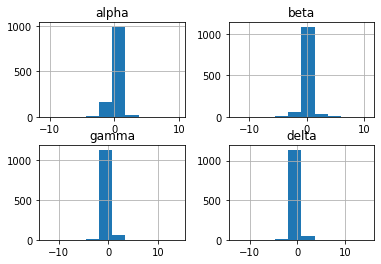

In [18]:
e_u_yeo.hist()

In [19]:
#e_u_yeo = e_u_yeo.head(100)
#states = states.head(100)

In [20]:
for lag_size in range(1, 20):
#for lag_size in [3]:
    rf_scores = []
    var_scores = []
    varmax_scores = []
    baseline_scores = []
    
    s = time.time()
    tscv = TimeSeriesSplit(10)
    #for train_index, test_index in tscv.split(e_u_yeo):
    for split_num, (train_index, test_index) in enumerate(list(tscv.split(e_u_yeo))[-3:]):
        #print(f"{split_num=}, {lag_size=}")
        #print(f"{train_index=}")
        #print(f"{test_index=}")
       
        train_orig = e_u_yeo.iloc[train_index]
        test_orig = e_u_yeo.iloc[test_index]
        pt = PowerTransformer()
        train = pd.DataFrame(pt.fit_transform(train_orig), columns=train_orig.columns)
        test = pd.DataFrame(pt.transform(test_orig), columns=test_orig.columns)
        
        #print(f"{train.shape=}")
        #print(f"{test.shape=}")

        test_len = min(30, test.shape[0])
        
        states_train = states.iloc[train_index]
        states_test = states.iloc[test_index]
        
        rf_predictions = []
        train_var = train.copy()
        for i in range(0, test_len): 
            p = dt_prediction(train_var, lag=lag_size)
            rf_predictions.append(p)            
            train_var = train_var.append(test.iloc[i])
            
        rf_rmse = mean_squared_error(np.array(rf_predictions), test[:test_len])
        #print(f"{rf_rmse=}")
        
        '''
        varmax_predictions = []
        train_var = train.copy()
        states_train_var = states_train.copy()
        for i in range(0, test_len): 
            exog = states_train_var[['RedemptionPriceError',
                                     'RedemptionPriceinEth', 
                                     'marketPriceUsd',
                                     'ETH Price (OSM)']].values
            new_exog = [states_test['RedemptionPriceError'].values[i],
                        states_test['RedemptionPriceinEth'].values[i],
                        states_test['marketPriceUsd'].values[i],
                        states_test['ETH Price (OSM)'].values[i]]
            #p = VARMAX_prediction2(train_var, states_train_var['RedemptionPriceError'],
            #          states_test['RedemptionPriceError'].values[i], steps=1, lag=lag_size)
            p = VARMAX_prediction2(train_var, exog, new_exog,                         
                                   steps=1, lag=lag_size)
            varmax_predictions.append(p[0,:])
            train_var = train_var.append(test.iloc[i])
            states_train_var = states_train_var.append(states_test.iloc[i])
   
        vmax_rmse = mean_squared_error(np.array(varmax_predictions), test[:test_len]) 
        print(f"{vmax_rmse=}")
        '''
    
        var_predictions = []
        train_var = train.copy()
        for i in range(0, test_len): 
            var_predictions.append(VAR_prediction(train_var, lag_size))
            train_var = train_var.append(test.iloc[i])
            
        var_rmse = mean_squared_error(np.array(var_predictions), test[:test_len])
        #print(f"{var_rmse=}")
                                                                     
        baseline = np.mean(train.values, axis=0).reshape(1, -1).repeat(test_len, axis=0)
        baseline_rmse = mean_squared_error(baseline, test[:test_len])
     
        rf_scores.append(rf_rmse)
        var_scores.append(var_rmse)
        #varmax_scores.append(vmax_rmse)
        baseline_scores.append(baseline_rmse)

    print(f"{lag_size=}, mean/std var score={np.mean(var_scores):.3f}/{np.std(var_scores):.3f}; "
          f"mean/std varmax score={np.mean(varmax_scores):.3f}/{np.std(varmax_scores):.3f}; "
          f"mean/std rf score={np.mean(rf_scores):.3f}/{np.std(rf_scores):.3f}; "
          f"mean/std baseline score:{np.mean(baseline_scores):.3f}/{np.std(baseline_scores):.3f} "
          f"time: {(time.time() - s):.1f}")


lag_size=1, mean/std var score=5.169/5.798; mean/std varmax score=nan/nan; mean/std rf score=5.456/6.019; mean/std baseline score:5.422/6.019 time: 14.1
lag_size=2, mean/std var score=4.876/5.548; mean/std varmax score=nan/nan; mean/std rf score=5.453/5.976; mean/std baseline score:5.422/6.019 time: 15.0
lag_size=3, mean/std var score=4.727/5.383; mean/std varmax score=nan/nan; mean/std rf score=5.439/6.037; mean/std baseline score:5.422/6.019 time: 15.3
lag_size=4, mean/std var score=4.615/5.278; mean/std varmax score=nan/nan; mean/std rf score=5.453/6.016; mean/std baseline score:5.422/6.019 time: 15.3
lag_size=5, mean/std var score=4.499/5.153; mean/std varmax score=nan/nan; mean/std rf score=5.438/6.015; mean/std baseline score:5.422/6.019 time: 15.5
lag_size=6, mean/std var score=4.472/5.115; mean/std varmax score=nan/nan; mean/std rf score=5.430/6.014; mean/std baseline score:5.422/6.019 time: 15.5
lag_size=7, mean/std var score=4.447/5.091; mean/std varmax score=nan/nan; mean/st

In [21]:
# invert the power transformation
var_predictions = invert_power_transformation(pt,var_predictions)
#varmax_predictions = invert_power_transformation(pt,varmax_predictions)


In [22]:
rf_predictions = invert_power_transformation(pt,rf_predictions)

## Model Evaluation Comparision (in coordinate transformed and power transformed differenced space)  

In [23]:
var_predictions_df = pd.DataFrame(var_predictions,columns=['alpha','beta','gamma','delta'])
rf_predictions_df = pd.DataFrame(rf_predictions,columns=['alpha','beta','gamma','delta'])

In [24]:
var_alpha_rmse = m.sqrt(mean_squared_error(var_predictions_df['alpha'], test.head(30)['alpha']))
rf_alpha_rmse = m.sqrt(mean_squared_error(rf_predictions_df['alpha'], test.head(30)['alpha']))
var_beta_rmse = m.sqrt(mean_squared_error(var_predictions_df['beta'], test.head(30)['beta']))
rf_beta_rmse = m.sqrt(mean_squared_error(rf_predictions_df['beta'], test.head(30)['beta']))
var_gamma_rmse = m.sqrt(mean_squared_error(var_predictions_df['gamma'], test.head(30)['gamma']))
rf_gamma_rmse = m.sqrt(mean_squared_error(rf_predictions_df['gamma'], test.head(30)['gamma']))
var_delta_rmse = m.sqrt(mean_squared_error(var_predictions_df['delta'], test.head(30)['delta']))
rf_delta_rmse = m.sqrt(mean_squared_error(rf_predictions_df['delta'], test.head(30)['delta']))

## Alpha - Root Mean Square Error

In [25]:

if var_alpha_rmse >= rf_alpha_rmse:
    print('RF performs better by {}'.format(rf_alpha_rmse-var_alpha_rmse))
else:
    print('VAR performs better by {}'.format(var_alpha_rmse-rf_alpha_rmse))

RF performs better by -0.20491231409763627


## Beta - Root Mean Square Error

In [26]:

if var_beta_rmse >= rf_beta_rmse:
    print('RF performs better by {}'.format(rf_beta_rmse-var_beta_rmse))
else:
    print('VAR performs better by {}'.format(var_beta_rmse-rf_beta_rmse))

RF performs better by -0.10628224522750207


## Gamma - Root Mean Square Error

In [27]:

if var_gamma_rmse >= rf_gamma_rmse:
    print('RF performs better by {}'.format(rf_gamma_rmse-var_gamma_rmse))
else:
    print('VAR performs better by {}'.format(var_gamma_rmse-rf_gamma_rmse))

VAR performs better by -0.05918024363527219


## Delta - Root Mean Square Error

In [28]:

if var_delta_rmse >= rf_delta_rmse:
    print('RF performs better by {}'.format(rf_delta_rmse-var_delta_rmse))
else:
    print('VAR performs better by {}'.format(var_delta_rmse-rf_delta_rmse))

VAR performs better by -0.23477363100490334


In [29]:
print('Aggregated RF RMSE in absolute values:')
print(abs(rf_alpha_rmse) + abs(rf_beta_rmse) + abs(rf_gamma_rmse) + abs(rf_delta_rmse))

print('Aggregated VAR RMSE in absolute values:')
print(abs(var_alpha_rmse) + abs(var_beta_rmse) + abs(var_gamma_rmse) + abs(var_delta_rmse))

Aggregated RF RMSE in absolute values:
4.220326263191287
Aggregated VAR RMSE in absolute values:
4.23756694787625


## Model Evaluation Comparision as States

In [30]:
def inverse_transformation_and_state_update(Y_pred,previous_state,params):
    '''
    Description:
    Function to take system identification model prediction and invert transfrom and create new state
    
    Parameters:
    y_pred: numpy array of transformed state changes
    previous_state: pandas dataframe of previous state or 'current' state
    params: dictionary of system parameters
    
    Returns:
    pandas dataframe of new states 
    
    Example:
    inverse_transformation_and_state_update(Y_pred,previous_state,params)
    '''
    
    d_star = Y_pred[0] * params['debt_ceiling']
    
    q_star = previous_state['C_o'] * params['debt_ceiling'] * Y_pred[0] + previous_state['C_1'] * Y_pred[1]
    
    r_star = Y_pred[2] * previous_state['gamma'] * previous_state['RaiInUniswap']

    z_star = Y_pred[3] * previous_state['delta'] * previous_state['EthInUniswap']

    new_state = pd.DataFrame(previous_state[['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']].to_dict())
    new_state['Q'] = new_state['collateral'] + q_star
    new_state['D'] = new_state['RaiDrawnFromSAFEs'] + d_star
    new_state['R_Rai'] = new_state['RaiInUniswap'] + r_star
    new_state['R_Eth'] = new_state['EthInUniswap'] + z_star
    
    return new_state[['Q','D','R_Rai','R_Eth']]



In [31]:
VAR_new_states = []
index = -21
for i in range(0,20): 
    previous_state = states.iloc[train_var.index[index:index+1]]
    VAR_new_states.append(inverse_transformation_and_state_update(var_predictions[i],previous_state,params))
    index += 1
    
VAR_new_states = pd.concat(VAR_new_states)
VAR_new_states

,Q,D,R_Rai,R_Eth
9,7.983688e+05,4.406016e+08,3.221382e+07,47418.271923
10,2.714039e+06,1.380586e+09,3.222043e+07,47359.077741
11,8.308632e+05,4.565407e+08,3.222825e+07,46791.726628
12,-9.526816e+05,-4.381227e+08,3.224126e+07,47087.000706
13,-1.237626e+06,-6.156471e+08,3.215952e+07,47284.854403
14,-1.793373e+06,-8.476141e+08,3.248509e+07,46694.253141
15,1.424649e+06,7.625678e+08,3.200373e+07,46723.472486
16,-1.356731e+06,-6.380567e+08,3.154422e+07,46334.399352
17,-7.172015e+05,-3.054345e+08,3.136661e+07,46646.755680
18,6.078251e+05,3.158226e+08,2.857484e+07,43848.432150


In [32]:
RF_new_states = []
index = -21
for i in range(0,20): 
    previous_state = states.iloc[train_var.index[index:index+1]]
    RF_new_states.append(inverse_transformation_and_state_update(rf_predictions[i], previous_state, params))
    index += 1
    
RF_new_states = pd.concat(RF_new_states)
RF_new_states

,Q,D,R_Rai,R_Eth
9,45610.130993,5.613293e+07,3.221757e+07,47397.789316
10,9512.066363,3.816791e+07,3.221994e+07,47362.619603
11,45784.307355,5.610577e+07,3.224134e+07,47091.306919
12,32974.168907,4.976556e+07,3.224147e+07,47086.965679
13,-16256.375979,2.627772e+07,3.228017e+07,47012.038026
14,-9885.960164,2.839865e+07,3.201354e+07,46644.638341
15,13710.794250,3.999954e+07,3.192603e+07,46779.284731
16,26332.973904,4.581620e+07,3.160816e+07,46343.194027
17,5951.613362,3.565576e+07,3.138462e+07,46735.545032
18,-9422.220987,2.760039e+07,2.988391e+07,44336.890015


In [33]:
test_data = states.iloc[test.index[0:20]][['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']]


In [34]:
test_data

,collateral,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs
0,6921.6132,47370.263641,3.211457e+07,3.669856e+07
1,6921.6132,47388.171967,3.210247e+07,3.669856e+07
2,6913.6132,47387.538619,3.210178e+07,3.669856e+07
3,6913.6132,47475.841207,3.217051e+07,3.676330e+07
4,6911.2132,47245.283268,3.228967e+07,3.680853e+07
5,6911.2132,47241.619624,3.229027e+07,3.680853e+07
6,6911.2132,47243.249632,3.229165e+07,3.680978e+07
7,6911.2132,47240.443483,3.229219e+07,3.681108e+07
8,6911.2132,47377.475539,3.220191e+07,3.681268e+07
9,6911.2132,47398.092793,3.221752e+07,3.683902e+07


## Q - Root Mean Square Error

In [35]:
var_q_rmse = m.sqrt(mean_squared_error(VAR_new_states['Q'], test_data['collateral']))
rf_q_rmse = m.sqrt(mean_squared_error(RF_new_states['Q'], test_data['collateral']))
if var_q_rmse >= rf_q_rmse:
    print('RF performs better by {}'.format(rf_q_rmse-var_q_rmse))
else:
    print('VAR performs better by {}'.format(var_q_rmse-rf_q_rmse))

RF performs better by -1281114.0360710486


## D - Root Mean Square Error

In [36]:
var_d_rmse = m.sqrt(mean_squared_error(VAR_new_states['D'], test_data['RaiDrawnFromSAFEs']))
rf_d_rmse = m.sqrt(mean_squared_error(RF_new_states['D'], test_data['RaiDrawnFromSAFEs']))
if var_d_rmse >= rf_d_rmse:
    print('RF performs better by {}'.format(rf_d_rmse-var_d_rmse))
else:
    print('VAR performs better by {}'.format(var_d_rmse-rf_d_rmse))

RF performs better by -629770937.4714025


## R_Rai - Root Mean Square Error

In [37]:
var_rai_rmse = m.sqrt(mean_squared_error(VAR_new_states['R_Rai'], test_data['RaiInUniswap']))
rf_rai_rmse = m.sqrt(mean_squared_error(RF_new_states['R_Rai'], test_data['RaiInUniswap']))
if var_rai_rmse >= rf_rai_rmse:
    print('RF performs better by {}'.format(rf_rai_rmse-var_rai_rmse))
else:
    print('VAR performs better by {}'.format(var_rai_rmse-rf_rai_rmse))

RF performs better by -159350.60098525113


## R_Eth - Root Mean Square Error

In [38]:
var_eth_rmse = m.sqrt(mean_squared_error(VAR_new_states['R_Eth'], test_data['EthInUniswap']))
rf_eth_rmse = m.sqrt(mean_squared_error(RF_new_states['R_Eth'], test_data['EthInUniswap']))
if var_eth_rmse >= rf_eth_rmse:
    print('RF performs better by {}'.format(rf_eth_rmse-var_eth_rmse))
else:
    print('VAR performs better by {}'.format(var_eth_rmse-rf_eth_rmse))

RF performs better by -259.1098549413184


In [39]:
print('Aggregated RF RMSE in absolute values:')
print(abs(rf_eth_rmse) + abs(rf_rai_rmse) + abs(rf_d_rmse) + abs(rf_q_rmse))

print('Aggregated VAR RMSE in absolute values:')
print(abs(var_eth_rmse) + abs(var_rai_rmse) + abs(var_d_rmse) + abs(var_q_rmse))

Aggregated RF RMSE in absolute values:
12418317.592532499
Aggregated VAR RMSE in absolute values:
643629978.8108463


### Exponential weighted moving average test grid

#### Aggregated RMSE values with VARMAX(1) and VAR(6)
VAR lags changed between alphas but for simplicity we held constant

|Alpha   |VARMAX RMSE   | VAR RMSE  | 
|---|---|---|
|0.1   |346,906.48   |356,511.48   |
|0.2  |355,980.48   |353,095.32   |
|0.3  |352,226.20   |350,923.13   |
|0.4  |347,489.97   |348,758.57  |
|0.5  |348,488.02  |347,155.68   |
|0.6  |348,345.53   |346,199.91   |
|0.7  |347,916.76   |345,765.18   |
|**0.8**  |348,061.60   |**345,692.82**   |
|0.9  |349,104.38   |346,223   |

## Conclusion


In this notebook we evaluated the performance of a VARMAX(1) model trained every 20 timesteps an the exogenous signal of redemption price error, against a VAR(15) model retrained everytime step. We decided on using a VAR(15) for the Rai Digital Twin because it performs slightly better, being able to retrain at every prediction timestep. 